# Fig. 6: Model shape predictions

In [1]:
import os
import pickle

import numpy as np
import pandas as pd

import argus_shapes

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-10-12 13:44:28,022 [pulse2percept] [INFO] Welcome to pulse2percept


In [2]:
data_dir = os.environ['ARGUS_SHAPES_DATA']
results_dir = '../results'
col_score = 'best_train_score'
col_groupby = ['subject', 'modelname', 'idx_fold']

In [3]:
subjectdata = argus_shapes.load_subjects(os.path.join(data_dir, 'subjects.csv'))
subjectdata['scale'] = pd.Series([0.75, 0.75, 1.5, 0.5], index=subjectdata.index)
subjects = subjectdata.index.sort_values()

In [4]:
# After repeatedely fitting the model, find the runs with the best training score:
try:
    files = argus_shapes.extract_best_pickle_files(results_dir, col_score, col_groupby)
except FileNotFoundError:
    argus_shapes.fetch_data(osf_zip_url='https://osf.io/prv5z', save_path=results_dir)
    files = argus_shapes.extract_best_pickle_files(results_dir, col_score, col_groupby)

In [5]:
y_true = []
y_pred = []
for file in files:
    yt, yp, best_params, specifics = pickle.load(open(file, 'rb'))
    xy = argus_shapes.calc_mean_images(yt[0], groupby=['electrode'],
                                       thresh=False, max_area=np.inf)
    xy['subject'] = specifics['subject']
    xy['modelname'] = '0'
    xy['rho'] = best_params[0]['rho']
    if 'axlambda' in best_params[0]:
        xy['axlambda'] = best_params[0]['axlambda']
    y_true.append(xy)
    xy = argus_shapes.calc_mean_images(yp[0], groupby=['electrode'],
                                           thresh=False, max_area=np.inf)
    xy['subject'] = specifics['subject']
    xy['modelname'] = specifics['modelname']
    xy['rho'] = best_params[0]['rho']
    if 'axlambda' in best_params[0]:
        xy['axlambda'] = best_params[0]['axlambda']
    y_pred.append(xy)

In [6]:
y_true = pd.concat(y_true).drop(columns=['x_center', 'y_center'])
y_pred = pd.concat(y_pred).drop(columns=['x_center', 'y_center'])

In [7]:
# Scaling factors for visualization:
scale_axon = subjectdata.copy()
scale_axon['scale'] = pd.Series([1.0, 1.0, 1.25, 0.75], index=scale_axon.index)
scale_score = subjectdata.copy()
scale_score['scale'] = pd.Series([1.0, 1.0, 2.0, 2.5], index=scale_score.index)

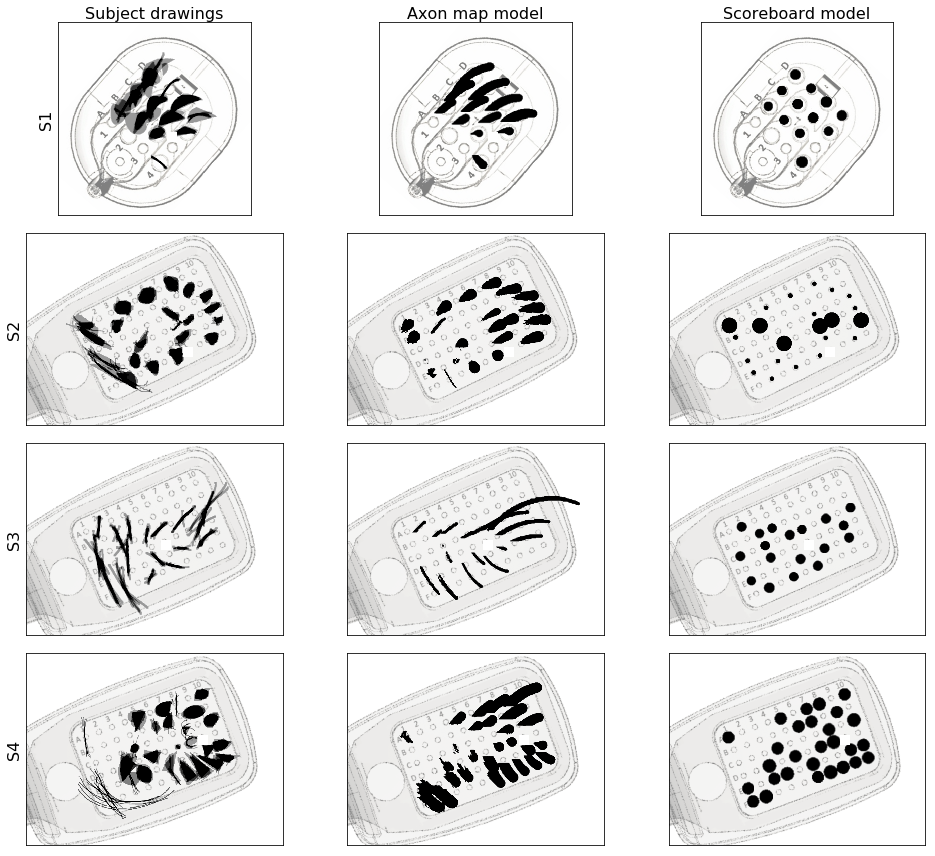

In [8]:
fig, axes = plt.subplots(nrows=len(subjects), ncols=3,
                         figsize=(14, 3 * len(subjects)))
for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
for i, title in enumerate(['Subject drawings', 'Axon map model', 'Scoreboard model']):
    axes[0][i].set_title(title, fontsize=16)
for subject, axrow in zip(subjects, axes):
    argus_shapes.viz.plot_phosphenes_on_array(axrow[0], subject, y_true[y_true.modelname=='0'], subjectdata)
    argus_shapes.viz.plot_phosphenes_on_array(axrow[1], subject, y_pred[y_pred.modelname=='C'], scale_axon)
    argus_shapes.viz.plot_phosphenes_on_array(axrow[2], subject, y_pred[y_pred.modelname=='A'], scale_score)
    axrow[0].set_ylabel(subject, fontsize=16)
fig.tight_layout()
fig.savefig('fig6-model-shapes.eps')